In [1]:
import textacy
from functools import partial
import numpy as np
import spacy
import matplotlib.pyplot as plt
import pandas as pd
import textacy.tm
import warnings
import gensim
import gensim.downloader as api
from collections import Counter
from gensim.models import KeyedVectors
import os
import itertools

Path = os.getcwd()


warnings.filterwarnings("ignore", category=FutureWarning)

#### Warning
- One needs to download the 'frWiki_no_phrase_no_postag_700_cbow_cut100.bin' from https://fauconnier.github.io/ to run this jupyter notebook
- The above corpus uses french wikipedia corpus to do NLP

In [2]:
Path_data = Path[:-4]+'/data/'
Path_plot = Path[:-4]+'/plots/'

In [3]:
model_glove_french = KeyedVectors.load_word2vec_format("frWiki_no_phrase_no_postag_700_cbow_cut100.bin",unicode_errors="ignore", binary=True )
model_glove_wiki = api.load("glove-wiki-gigaword-100")

In [4]:
lang = 'fr_core_news_lg'

In [5]:
#### Combining the two twitter datasets
df1 = pd.read_csv(Path_data+'tweets_tierslieux_30000.csv')
df2 = pd.read_csv(Path_data+'tweets_tierslieu_30000.csv')


df_tweets = pd.DataFrame(columns=['id','text','hashtags','timestamp_utc','year','month','day'])

for temp_df in [df1,df2]:
    new_df = pd.DataFrame(columns=['id','text','hashtags','timestamp_utc','year','month','day'])
    for cols in ['id','text','hashtags','timestamp_utc']:
        new_df[cols] = temp_df[cols]

    date = pd.to_datetime(temp_df['timestamp_utc'], unit='s')
    new_df['year'] = pd.DatetimeIndex(date).year
    new_df['month'] = pd.DatetimeIndex(date).month
    new_df['day'] = pd.DatetimeIndex(date).day

    df_tweets = pd.concat([df_tweets,new_df])

df_tweets = df_tweets.drop_duplicates(ignore_index=True)
df_tweets = df_tweets.sort_values(by=['timestamp_utc'], ascending=True,ignore_index=True)

ori_hashtag = df_tweets['hashtags']

for i, hasht in enumerate(ori_hashtag):
    temp_hasht = hasht.split('|')
    temp_hasht = [ht for ht in temp_hasht if ht!='tierslieux']
    temp_hasht = [ht for ht in temp_hasht if ht!='tierslieu']
    ori_hashtag[i] = temp_hasht

df_tweets['hashtags'] = ori_hashtag
df_tweets.to_csv(Path_data+'tweets_combined.csv')

years = list(np.unique(df_tweets['year']))
years

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

In [6]:
df_website = pd.read_csv(Path_data+'commune_mesure_website_data.csv')

In [7]:
year_topic_list_french, year_topic_list_wiki, year_tweet_num_list = ([] for x in range(3))
year_hashtag_list, year_hastag_num_list = ([] for x in range(2))

nlp = spacy.load('fr_core_news_lg')

for year in years:
    df_year = df_tweets.copy(deep=True)
    df_year = df_year[df_year['year']==year]
    temp_documents = list(df_year['text'].str.lower())

    year_tweet_num_list.append(len(df_year))
    
    corpus = textacy.Corpus(lang)
    for item in ['parser']:
        if item in corpus.spacy_lang.pipe_names:
            corpus.spacy_lang.remove_pipe(item)

    corpus.add_texts(temp_documents) 

    docs_terms = (textacy.extract.terms(doc,ngs=partial(textacy.extract.ngrams, n=1, include_pos={"NOUN", "ADJ","VERB"}),ents=partial(textacy.extract.entities, include_types={ "ORG", "GPE", "LOC"}))for doc in corpus)
    tokenized_docs = (textacy.extract.terms_to_strings(doc_terms, by="lemma") for doc_terms in docs_terms)
    doc_term_matrix, vocab = textacy.representations.build_doc_term_matrix(tokenized_docs,tf_type="linear", idf_type="smooth")
    id_to_term = {id_: term for term, id_ in vocab.items()}

    model = textacy.tm.TopicModel("nmf", n_topics=1, max_iter=5000)
    model.fit(doc_term_matrix)
    doc_topic_matrix = model.transform(doc_term_matrix)

    word_list = list(model.top_topic_terms(id2term=id_to_term,topics=[0],top_n=10))

    word_axis_french = np.zeros(shape=(700,))
    word_axis_wiki = np.zeros(shape=(100,))
    for k in range(len(word_list[0][1])):
        try:
            word_axis_wiki += model_glove_wiki.get_vector(word_list[0][1][k])
        except:
            pass

        try:
            word_axis_french += model_glove_french.get_vector(word_list[0][1][k])
        except:
            pass

    final_word_french = model_glove_french.most_similar(positive=[word_axis_french], topn=5)  
    final_word_wiki = model_glove_wiki.most_similar(positive=[word_axis_wiki], topn=5)  

    year_topic_list_french.append(final_word_french)
    year_topic_list_wiki.append(final_word_wiki)

    print(f'year {year} is done.')

year 2010 is done.
year 2011 is done.
year 2012 is done.
year 2013 is done.
year 2014 is done.
year 2015 is done.
year 2016 is done.
year 2017 is done.
year 2018 is done.
year 2019 is done.
year 2020 is done.
year 2021 is done.
year 2022 is done.


In [8]:
year_topic_list_wiki_final = [tp[0][0] if tp[0][0]!='=' else 'nouveau' for tp in year_topic_list_wiki]
year_topic_list_french_final = [tp[0][0] if tp[0][0]!='>' else tp[1][0] for tp in year_topic_list_french]
year_topic_list_wiki_final, year_topic_list_french_final

(['compagnie',
  'nouveau',
  'nouveau',
  'ville',
  'espace',
  'espace',
  'projet',
  'cinéma',
  'génie',
  'territoire',
  'territoire',
  'territoire',
  'projet'],
 ['immobilier',
  'télétravail',
  'télétravail',
  'télétravail',
  'télétravail',
  'télétravail',
  'innovation',
  'innovation',
  'numérique',
  'espace',
  'numérique',
  'numérique',
  'espace'])

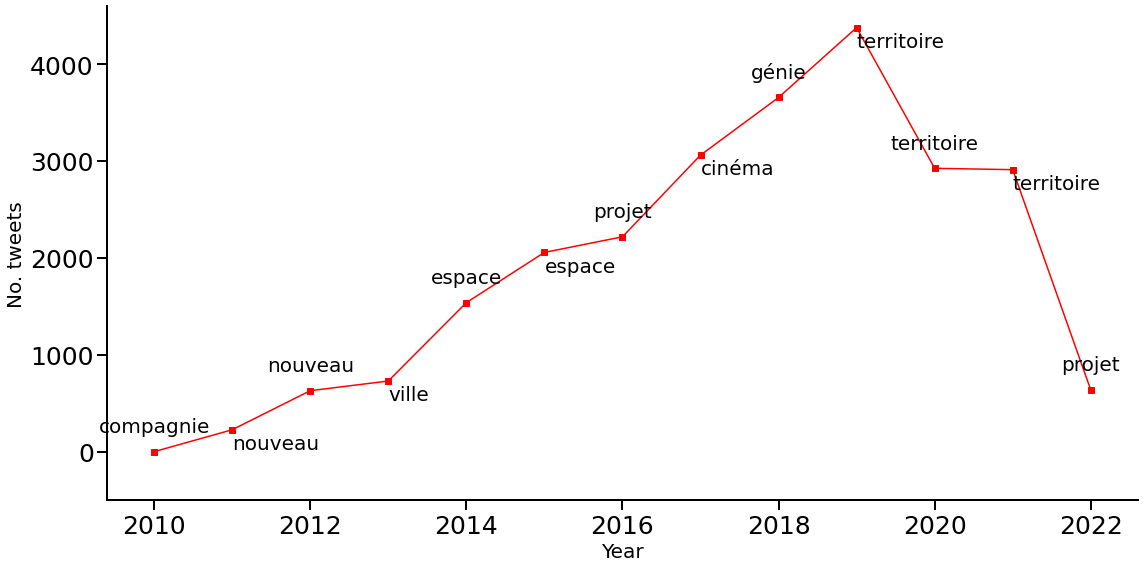

In [9]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(years,year_tweet_num_list,color='r',marker='s')

shift_ver = 200
shift_hor = 0.0
for i,year in enumerate(years):
    if i%2 == 0:
        ax.text(year-shift_hor,year_tweet_num_list[i]+shift_ver,year_topic_list_wiki_final[i],fontsize=20,ha='center')
    else:
        ax.text(year+shift_hor,year_tweet_num_list[i]-shift_ver,year_topic_list_wiki_final[i],fontsize=20)

ax.set_xlabel('Year',fontsize=20)
ax.set_ylabel('No. tweets',fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', labelsize=25, length=10, width=2)
ax.set_ylim(ymin=-500)

plt.tight_layout()
plt.savefig(Path_plot+'tweets_topic_time_wiki.jpeg', dpi=100)

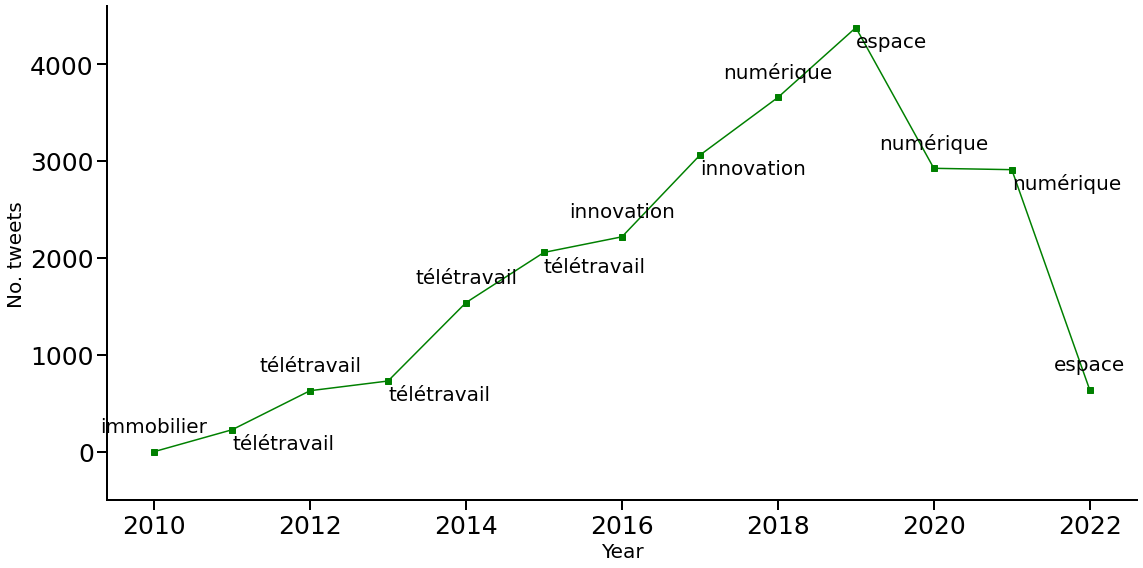

In [10]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(years,year_tweet_num_list,color='g',marker='s')

shift_ver = 200
shift_hor = 0.0
for i,year in enumerate(years):
    if i%2 == 0:
        ax.text(year-shift_hor,year_tweet_num_list[i]+shift_ver,year_topic_list_french_final[i],fontsize=20,ha='center')
    else:
        ax.text(year+shift_hor,year_tweet_num_list[i]-shift_ver,year_topic_list_french_final[i],fontsize=20)

ax.set_xlabel('Year',fontsize=20)
ax.set_ylabel('No. tweets',fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', labelsize=25, length=10, width=2)
ax.set_ylim(ymin=-500)

plt.tight_layout()
plt.savefig(Path_plot+'tweets_topic_time_french.jpeg', dpi=100)

In [11]:
year_hashtag1_list, year_hashtag1_num_list = ([] for x in range(2))
year_hashtag2_list, year_hashtag2_num_list = ([] for x in range(2))

for year in years[1:]:
    df_year = df_tweets.copy(deep=True)
    df_year = df_year[df_year['year']==year]
    
    ################ HASHTAG ANALYSIS ###############################
    temp_hashtag = list(df_year['hashtags'])
    temp_hashtag = [item for sublist in temp_hashtag for item in sublist]
    temp_hashtag_dict = Counter(temp_hashtag)
    temp_hashtag_sort = sorted(temp_hashtag_dict.items(),key=(lambda i: i[1]))

    year_hashtag1_list.append(temp_hashtag_sort[-1][0])
    year_hashtag1_num_list.append(temp_hashtag_sort[-1][1])

    year_hashtag2_list.append(temp_hashtag_sort[-2][0])
    year_hashtag2_num_list.append(temp_hashtag_sort[-2][1])
    #################################################################

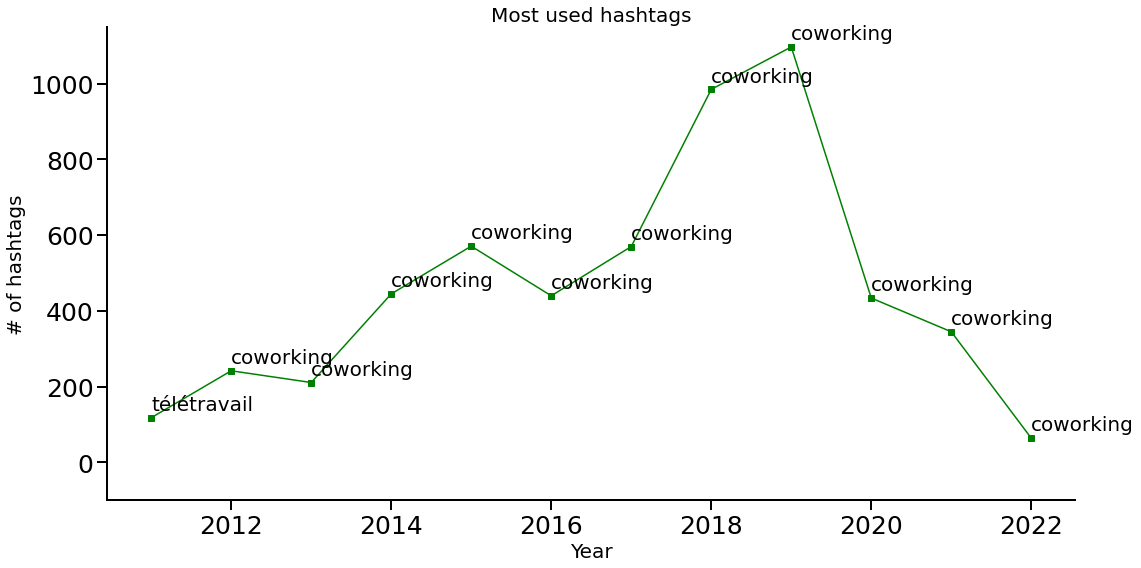

In [12]:

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(years[1:],year_hashtag1_num_list,color='g',marker='s')

shift_ver = 20
shift_hor = 0.0
for i,year in enumerate(years[1:]):
    if i%2 == 0:
        ax.text(year-shift_hor,year_hashtag1_num_list[i]+shift_ver,year_hashtag1_list[i],fontsize=20)
    else:
        ax.text(year+shift_hor,year_hashtag1_num_list[i]+shift_ver,year_hashtag1_list[i],fontsize=20)

ax.set_xlabel('Year',fontsize=20)
ax.set_ylabel('# of hashtags',fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', labelsize=25, length=10, width=2)
ax.set_ylim(ymin=-100)
ax.set_title('Most used hashtags',fontsize=20)

plt.tight_layout()
plt.savefig(Path_plot+'hashtags_most_used_time.jpeg', dpi=100)

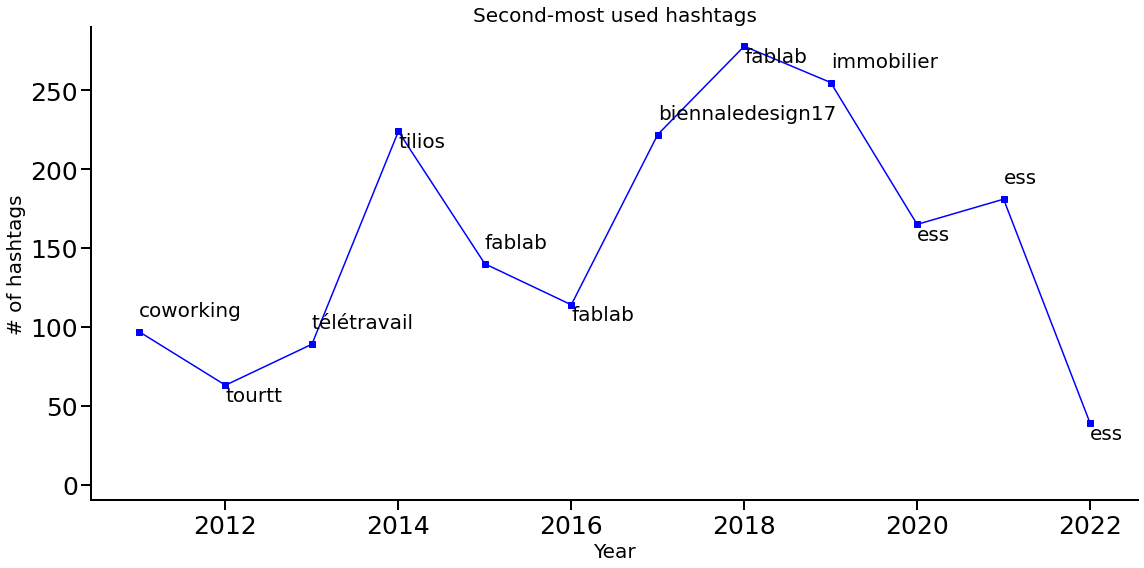

In [13]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(years[1:],year_hashtag2_num_list,color='b',marker='s')

shift_ver = 10
shift_hor = 0.0
for i,year in enumerate(years[1:]):
    if i%2 == 0:
        ax.text(year-shift_hor,year_hashtag2_num_list[i]+shift_ver,year_hashtag2_list[i],fontsize=20)
    else:
        ax.text(year-shift_hor,year_hashtag2_num_list[i]-shift_ver,year_hashtag2_list[i],fontsize=20)

ax.set_xlabel('Year',fontsize=20)
ax.set_ylabel('# of hashtags',fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', labelsize=25, length=10, width=2)
ax.set_ylim(ymin=-10)
ax.set_title('Second-most used hashtags',fontsize=20)

plt.tight_layout()
plt.savefig(Path_plot+'hashtags_second_most_used_time.jpeg', dpi=100)

In [14]:
place_name = list(df_website['Name'])


values_df = list(df_website['values carried'])
values_list = []
for vd in values_df:
    if str(vd) != 'nan':
        values_list.append(vd.split(','))

values_list = [item for sublist in values_list for item in sublist]
values_freq = Counter(values_list)
values_freq = sorted(values_freq.items(),key=(lambda i: i[1]))
values_freq

[('Transmission', 2),
 ('Durabilité', 2),
 ('Inclusivité', 7),
 ('Environnement', 7),
 ('Partage', 10),
 ('Accueil', 18),
 ('Créativité', 20),
 ('Coopération', 20),
 ('Convivialité', 22)]

In [15]:
values_name = [v for (v,f) in values_freq]
values_time = [f for (v,f) in values_freq]

In [16]:
values_name_tweet, values_time_tweet = ([] for x in range(2))
values_tweet_year = []
for vf in itertools.combinations(values_freq,1):
    df_value = df_tweets.copy(deep=True)
    mask = np.column_stack([df_value['text'].str.contains((str(vf[0][0].lower())), na=False)])
    df_value = df_value.loc[mask.any(axis=1)]
    values_name_tweet.append((str(vf[0][0].lower())))
    values_time_tweet.append(len(df_value))
    # print(str(vf[0].lower()),len(df_value))

    temp_values_tweet_year = []
    for year in years:
        df_value_year = df_value.copy(deep=True)
        df_value_year = df_value_year[df_value_year['year']==year]
        temp_values_tweet_year.append(len(df_value_year))

    values_tweet_year.append(temp_values_tweet_year)

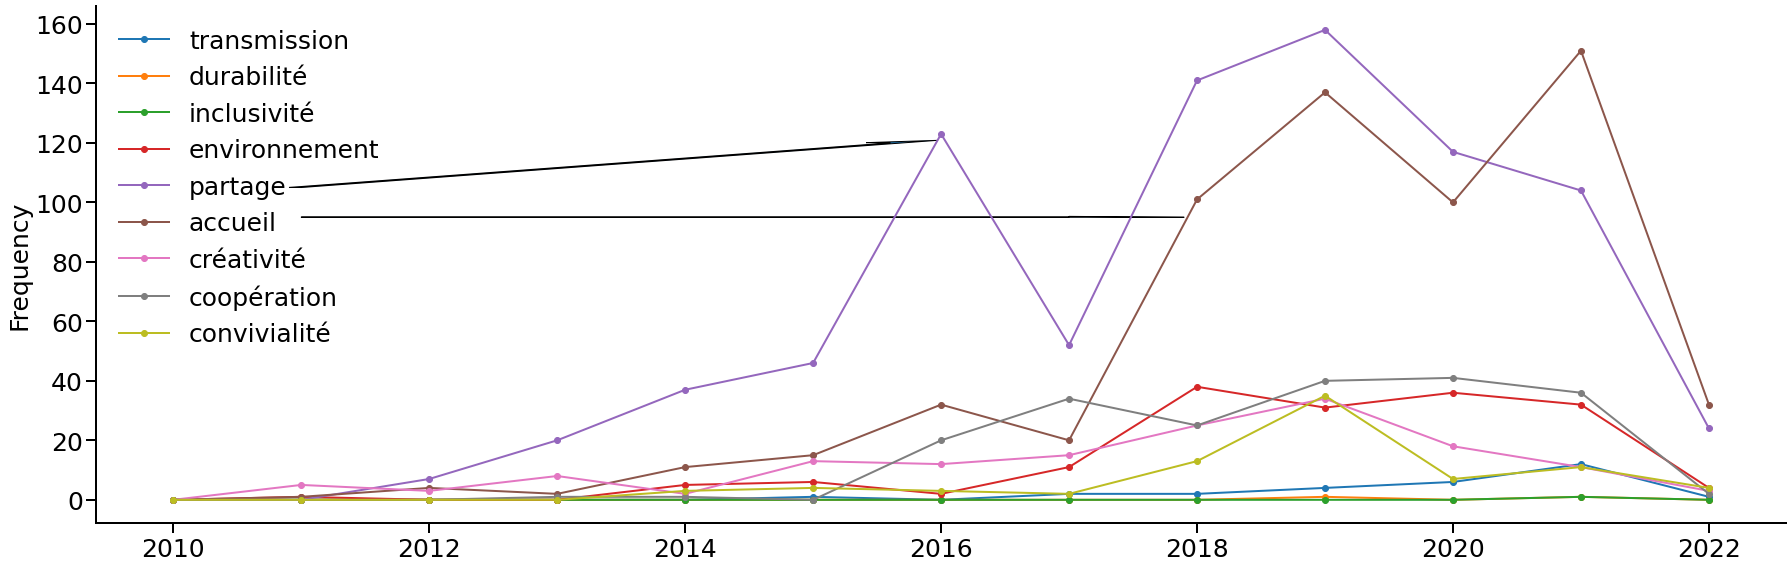

In [17]:
fig, ax = plt.subplots(1,1,figsize=(25,8))

for i,vnt in enumerate(values_name_tweet):
    ax.plot(years,values_tweet_year[i],marker='o',linewidth=2,label=vnt)

ax.set_ylabel('Frequency',fontsize=25)

ax.tick_params(axis='both', which='major', labelsize=25, length=10, width=2)

ax.legend(frameon=False,fontsize=25)

ax.arrow(2011,105,4.7,15,shape='right',width=0.2,capstyle='round')
ax.arrow(2011,95,6,0,shape='right',width=0.2,capstyle='round')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

plt.tight_layout()
plt.savefig(Path_plot+'tweets_values_carried_year.jpeg',dpi=100)
plt.show()

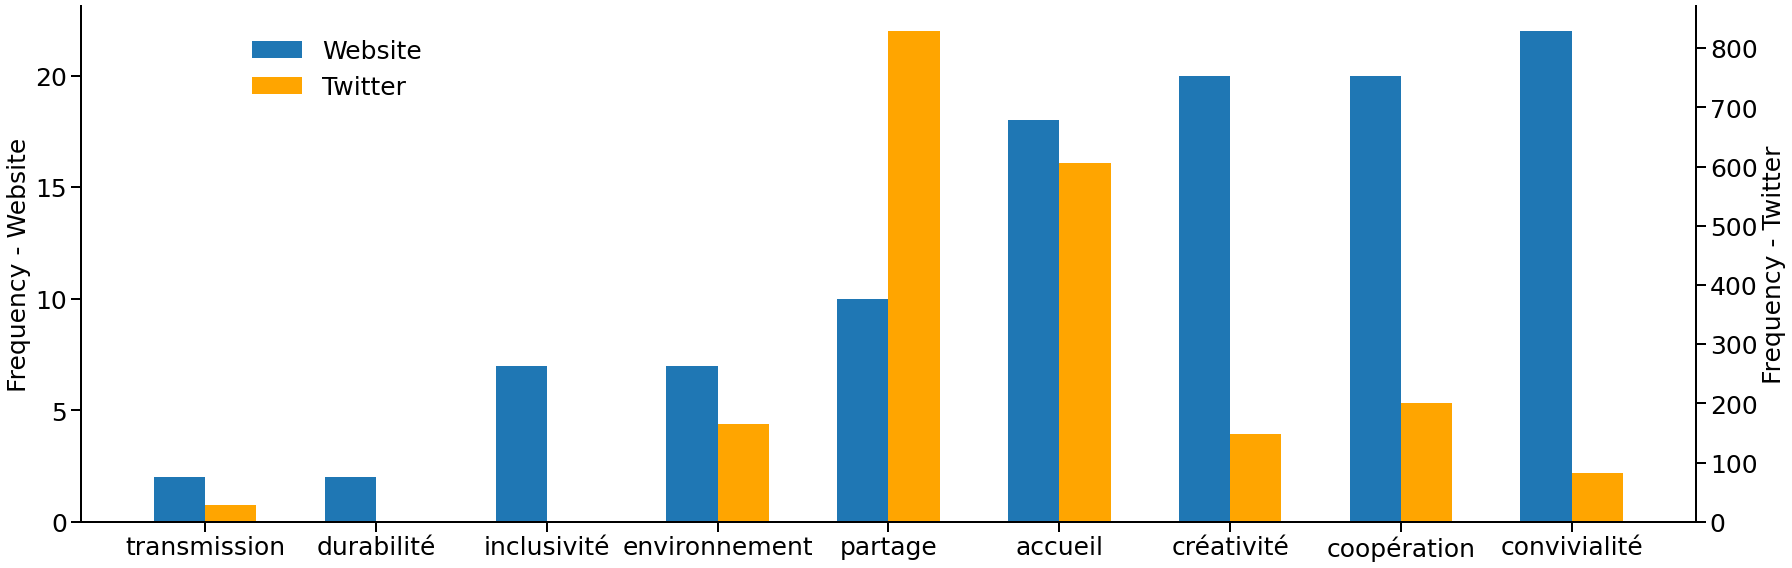

In [18]:
x_marks = np.arange(len(values_name_tweet))


fig, ax = plt.subplots(1,1,figsize=(25,8))

ax2 = ax.twinx()

width = 0.15

ax.bar(x=x_marks-width,width=2*width,height=values_time,label='Website')
ax2.bar(x=x_marks+width,width=2*width,height=values_time_tweet,label='Twitter',color='orange')
ax.set_xticks(x_marks)
ax.set_xticklabels(values_name_tweet,rotation=0,fontsize=25,horizontalalignment='center')

ax.set_ylabel('Frequency - Website',fontsize=25)
ax2.set_ylabel('Frequency - Twitter',fontsize=25)

ax.legend(frameon=False,fontsize=25,loc=(0.1,0.87))
ax2.legend(frameon=False,fontsize=25,loc=(0.1,0.8))

for ax in [ax,ax2]:
    ax.tick_params(axis='both', which='major', labelsize=25, length=10, width=2)

    ax.spines['top'].set_visible(False)

    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)


plt.tight_layout()
plt.savefig(Path_plot+'tweet_vs_website_combined.jpeg',dpi=100)
plt.show()

In [19]:
website_values = list(np.unique(list(df_website['values carried'])))
website_values = [str(wv) for wv in website_values if wv != 'nan']

values_name_website, values_time_website = ([] for x in range(2))
values_name_tweet, values_time_tweet = ([] for x in range(2))

for wv in itertools.combinations(website_values,1):

    ##### Website #############################################
    df_website_value = df_website.copy(deep=True)
    df_website_value['values carried'] = df_website_value['values carried'].str.lower()
    ##### Twitter #############################################
    df_tweet_value = df_tweets.copy(deep=True)
    df_tweet_value['text'] = df_tweet_value['text'].str.lower()

    wv = str(wv).split(',')
    wv = [twv.replace('(','').replace('\'','').replace(')','') for twv in wv if twv!=')']
    num_values = len(wv)

    temp_name = []
    for nv in range(num_values):
        mask_website = np.column_stack([df_website_value['values carried'].str.contains((str(wv[nv].lower())), na=False)])
        df_website_value = df_website_value.loc[mask_website.any(axis=1)]

        mask_twitter = np.column_stack([df_tweet_value['text'].str.contains((str(wv[nv].lower())), na=False)])
        df_tweet_value = df_tweet_value.loc[mask_twitter.any(axis=1)]

        temp_name.append((str(wv[nv].lower())))
    
    values_name_tweet.append(temp_name)
        
    values_time_website.append(len(df_website_value))
    values_time_tweet.append(len(df_tweet_value))

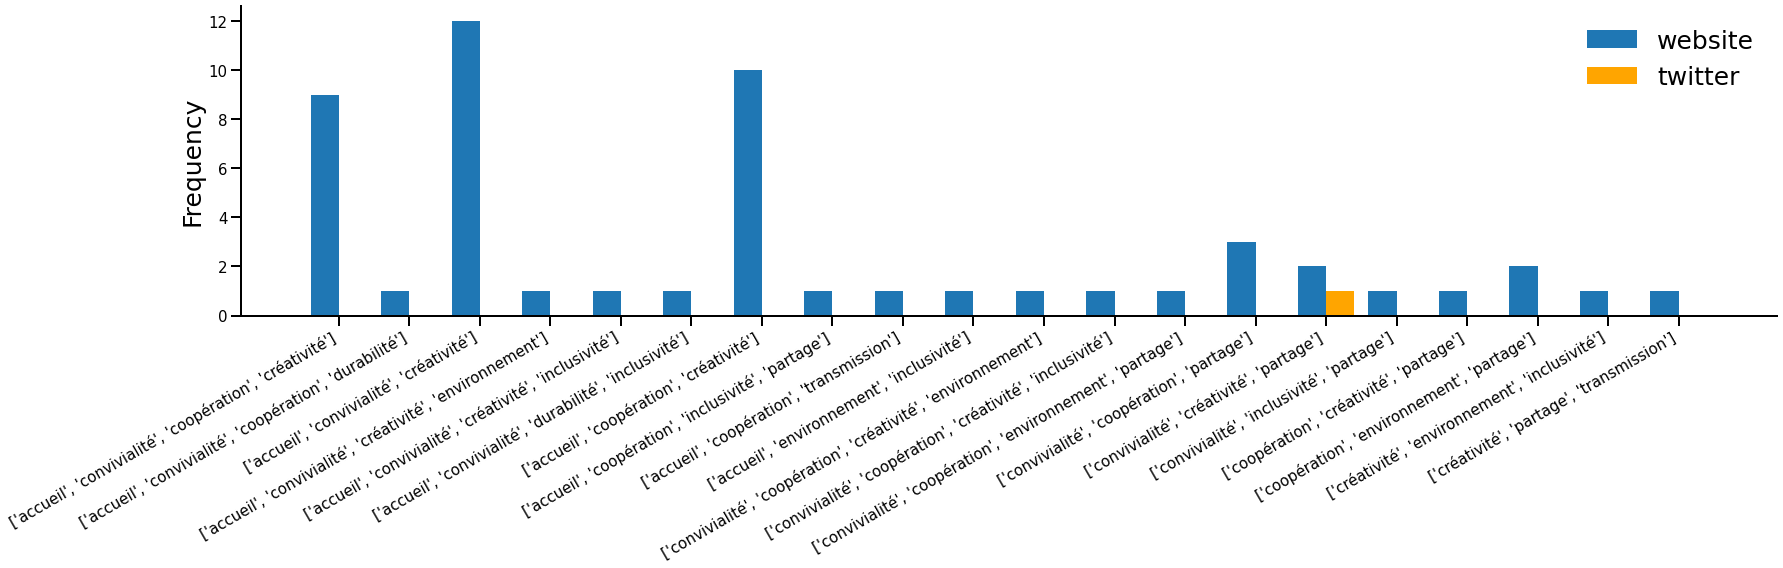

In [20]:
fig, ax = plt.subplots(1,1,figsize=(25,8))
k = len(values_time_tweet)

xmarks = np.arange(k-1)
width = 0.2

ax.bar(x=xmarks-width,width=2*width,height=values_time_website[:-1],label='website')
ax.bar(x=xmarks+width,width=2*width,height=values_time_tweet[:-1],label='twitter',color='orange')
ax.set_xticks(np.arange(k-1))
ax.set_xticklabels(values_name_tweet[:-1],rotation=30,horizontalalignment='right')

# ax.set_yscale('log')
ax.set_ylabel('Frequency',fontsize=25)

ax.tick_params(axis='both', which='major', labelsize=15, length=10, width=2)

ax.legend(frameon=False,fontsize=25)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

plt.tight_layout()
plt.savefig(Path_plot+'website_vs_twitter_site.jpeg',dpi=100)
plt.show()

In [21]:
website_values = list(np.unique(list(df_website['values carried'])))
website_values = [str(wv) for wv in website_values if wv != 'nan']

values_time_tweet_combination = []
for wv in itertools.combinations(website_values,1):

    ##### Website #############################################
    df_website_value = df_website.copy(deep=True)
    df_website_value['values carried'] = df_website_value['values carried'].str.lower()
    ##### Twitter #############################################
    df_tweet_value = df_tweets.copy(deep=True)
    df_tweet_value['text'] = df_tweet_value['text'].str.lower()

    wv = str(wv).split(',')
    wv = [twv.replace('(','').replace('\'','').replace(')','') for twv in wv if twv!=')']
    num_values = len(wv)

    temp_num = 0
    for nv1,nv2 in itertools.combinations(wv,2):
        df_tweet_value = df_tweets.copy(deep=True)
        mask_twitter = np.column_stack([df_tweet_value['text'].str.contains((str(nv1.lower())), na=False)])
        df_tweet_value = df_tweet_value.loc[mask_twitter.any(axis=1)]
        mask_twitter = np.column_stack([df_tweet_value['text'].str.contains((str(nv2.lower())), na=False)])
        df_tweet_value = df_tweet_value.loc[mask_twitter.any(axis=1)]
        temp_num+=len(df_tweet_value)
        
    values_time_tweet_combination.append(temp_num)

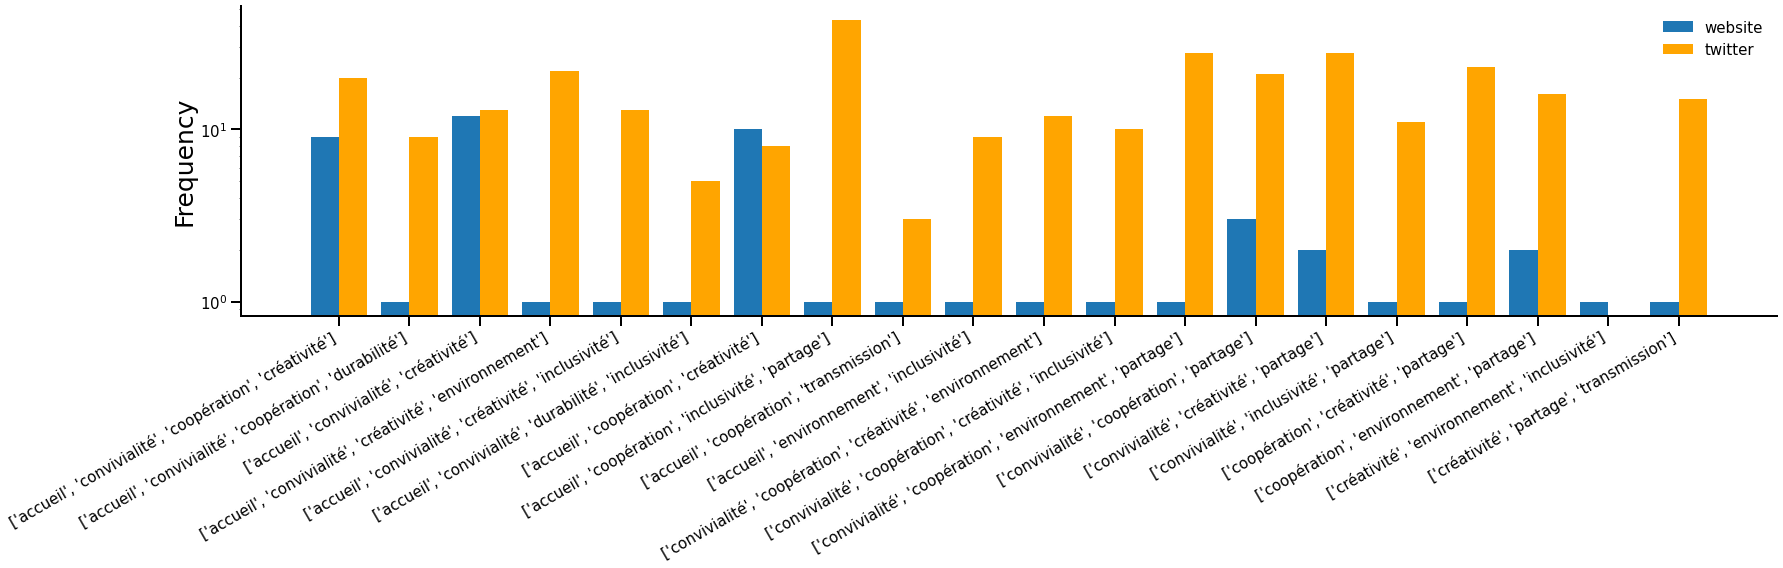

In [24]:
fig, ax = plt.subplots(1,1,figsize=(25,8))
k = len(values_time_tweet)

xmarks = np.arange(k-1)
width = 0.2

ax.bar(x=xmarks-width,width=2*width,height=values_time_website[:-1],label='website')
ax.bar(x=xmarks+width,width=2*width,height=values_time_tweet_combination[:-1],label='twitter',color='orange')
ax.set_xticks(np.arange(k-1))
ax.set_xticklabels(values_name_tweet[:-1],rotation=30,horizontalalignment='right')

ax.set_yscale('log')
ax.set_ylabel('Frequency',fontsize=25)

ax.tick_params(axis='both', which='major', labelsize=15, length=10, width=2)

ax.legend(frameon=False,fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

plt.tight_layout()
plt.savefig(Path_plot+'website_vs_twitter_site_any2.jpeg',dpi=100)
plt.show()